Read dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Import dataset
#file_name = "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv"
file_name = "../Datasets/ecg.csv"

dataframe = pd.read_csv(file_name)
dataset = dataframe.values

Train/Test data split and pre-processing

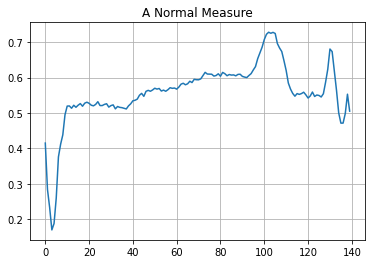

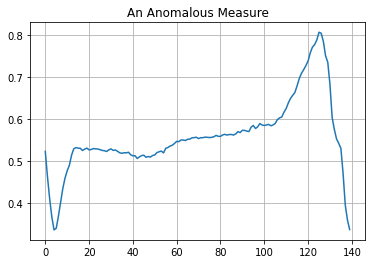

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(1337)

# The last element contains the labels
labels = dataset[:, -1]

# The other data points are the features
data = dataset[:, 0:-1]

# Dataset split (train & test)
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=1337
)

# Pre-processing
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

plt.grid()
plt.plot(np.arange(train_data.shape[1]), normal_train_data[0])
plt.title("A Normal Measure")
plt.show()

plt.grid()
plt.plot(np.arange(train_data.shape[1]), anomalous_train_data[0])
plt.title("An Anomalous Measure")
plt.show()

Autoencoder

In [8]:
import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard

hidden_activation = 'relu'
output_activation = 'linear'
hidden_size = 64
bottleneck_size = 2
input_size = train_data.shape[1]

class AnomalyDetector(Model):
  def __init__(self, hidden_activation, output_activation, hidden_size, bottleneck_size, input_size):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      Dense(hidden_size, activation=hidden_activation),
      #Dense(16, activation=hidden_activation),
      Dense(bottleneck_size, activation=hidden_activation)])

    self.decoder = tf.keras.Sequential([
      #Dense(16, activation=hidden_activation),
      Dense(hidden_size, activation=hidden_activation),
      Dense(input_size, activation=output_activation)])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector(hidden_activation, output_activation, hidden_size, bottleneck_size, input_size)

autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

epochs = 20
batch_size = 512

# Logs directory
log_dir = "logs/fit/" + file_name[0:4] + "..." + file_name[len(file_name)-4:len(file_name)] + "/" + hidden_activation + output_activation + "_neurons" + str(hidden_size) + "-" + str(bottleneck_size) + "_epoch" + str(epochs) + "_batch" + str(batch_size) + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

trainig_history = autoencoder.fit(normal_train_data, normal_train_data, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(test_data,test_data), verbose=1, callbacks=[tensorboard_callback])

plt.plot(trainig_history.history["loss"], label="Training Loss")
plt.plot(trainig_history.history["val_loss"], label="Validation Loss")
plt.legend()


AttributeError: 'NoneType' object has no attribute 'set_model'

Validation

In [4]:
# Functions

import itertools

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold), reconstructions, loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

Threshold:  0.005128524801693843


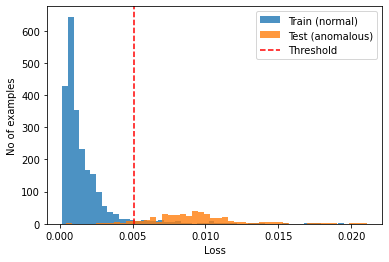

Accuracy = 0.947
Precision = 0.9533213644524237
Recall = 0.9516129032258065


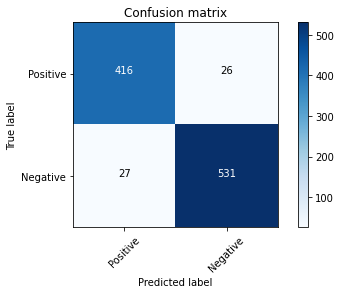

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, auc

# Plot the reconstruction error on normal Measures from the training set
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

# Choose a threshold value that is one standard deviations above the mean
# threshold = np.mean(train_loss) + np.std(train_loss)
threshold = np.percentile(train_loss, 95)
print("Threshold: ", threshold)

# Plot the reconstruction error on anomalous Measures from the test set
reconstructions = autoencoder.predict(anomalous_test_data)
anom_test_loss = tf.keras.losses.mse(reconstructions, anomalous_test_data)

plt.hist(train_loss[None,:], bins=50, alpha=0.8, label="Train (normal)")
plt.hist(anom_test_loss[None, :], bins=50, alpha=0.8, label="Test (anomalous)")
plt.axvline(x=threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Loss")
plt.ylabel("No of examples")
plt.legend(loc='best')
plt.show()

# Classify an Measure as an anomaly if the reconstruction error is greater than the threshold
pred_labels, pred_reconstructions, pred_loss = predict(autoencoder, test_data, threshold)
print_stats(pred_labels, test_labels)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, pred_labels)
cmplot = plot_confusion_matrix(conf_matrix, ["Positive","Negative"])

# # Precision-recall graph to determine threshold
# precision, recall, threshold = precision_recall_curve(test_labels, mse)

# plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
# plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
# plt.title('Precision & Recall to differentiate the threshold')
# plt.xlabel('Threshold')
# plt.ylabel('Precision/Recall')
# plt.legend()
# plt.show()


In [6]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.
